# **Time Series Analysis**

Kalau minggu lalu kita coba download file dari websitenya langsung, sekarang kita coba untuk download dari drive (gak harus drive kita, bisa drive orang juga selama izin sharing-nya dibuka)

In [ ]:
# Credential untuk mengakses Google Drive dari Google Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Autentikasi dan pembentukan PyDrive Client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1yyD-BLmFgNm37xXVmDMYd6IPfEVc54_I' 
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Electric_Production.csv')

Menampilkan Data pada Notebook

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from matplotlib_venn import venn3

In [ ]:
df = pd.read_csv("/content/Electric_Production.csv")
df.DATE = pd.to_datetime(df.DATE)
df.tail(5)

,DATE,IPG2211A2N
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212
396,2018-01-01,129.4048


## **Stationary Test**

### Rata - Rata Triwulan

Beberapa cara akan digunakan pada Stationary Test.

Yang pertama adalah mengamati Plot untuk melihat apakah Time Series mempunyai *seasonality*.

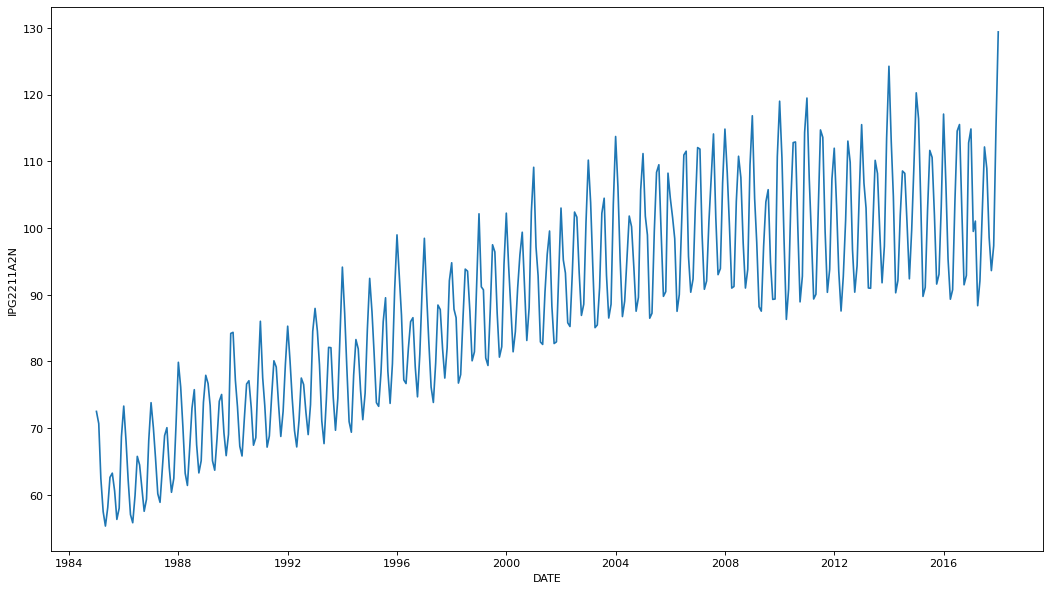

In [ ]:
x = df.set_index("DATE")
plt.figure(figsize=(16,9), dpi= 80)
sns.lineplot(data=x["IPG2211A2N"])
plt.show()

Cara kedua adalah mendapatkan Ringkasan Statistik untuk data dengan membagi data menjadi dua atau lebih bagian dan membandingkan rata-rata serta varian dari pembagian data tersebut. Jika rata-rata dan varian antara beberapa bagian data tidak mempunyai perbedaan yang signifikan, kemungkian data tersebut stationary.

In [ ]:
X = x.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=77.403591, mean2=100.233338
variance1=121.474139, variance2=90.385131


Cara ketiga yang digunakan adalah dengan menggunakan fungsi ADF langsung untuk mendapatkan informasi apakah data Stationary atau tidak.

In [ ]:
! pip install statsmodels
! pip install pmdarima 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [ ]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(X) 

(0.01, False)

Plot Time Series menampilkan bahwa ada kecenderungan tren pada data. Selisih antara pembagian dua data dan pembagian data dalam Triwulan memberikan selisih yang besar pada setiap rata-rata dan variannya. Terakhir, penggunaan Augmented Dickey–Fuller menggunakan library dari ARIMA menghasilkan hasil False untuk keadaan stationary pada data.


Hasil yang diberikan dari ketiga cara dapat disimpulkan bahwa Time Series yang digunakan **tidak** stationary.

more about stationary test :
- https://medium.com/swlh/stochasticity-test-for-time-series-5312f1325700

##**Prediksi dengan ARIMA**

Salah satu State-of-art Time Series Forecasting adalah ARIMA.

Auto Regressive Integrated Moving Average (ARIMA) sesuai namanya memanfaatkan auto-regressive, integrated, dan moving average.

In [ ]:
import os                     
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Pelatihan Model

In [ ]:
# Pelatihan untuk mendapatkan model ARIMA yang paling baik dengan perbaikan 
# penggunaan auto-regressive, integrated, dan moving average.
arima_best = auto_arima(df['IPG2211A2N'], seasonality=False,
           m=12,
           max_p=7, # Auto-Regressive (p) 
           max_d=5, # Integrated (d)
           max_q=7, # Moving Average (q)
           )

In [ ]:
arima_best.summary() # Model SARIMAX(1, 1, 2)x(1, 0, [1], 12)	
                     # menunjukkan hasil yang terbaik

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -925.940
Date:                              Mon, 30 Nov 2020   AIC                           1863.879
Time:                                      15:16:54   BIC                           1887.768
Sample:                                           0   HQIC                          1873.343
                                              - 397                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3746      0.090      4.179      0.000       0.199       0.550
ma.L1         -0.7292      0.088     -8.255      0.000      -0.902      -0.556
ma.L2         -0.2075      0.077     -2.708      0.007      -0.358      -0.057
ar.S.L12       0.9963      0.003    339.929      0.000       0.991       1.002
ma.S.L12      -0.7620      0.037    -20.515      0.000      -0.835      -0.689
sigma2         5.7417      0.325     17.670      0.000       5.105       6.379
===================================================================================
Ljung-Box (Q):                       65.28   Jarque-Bera (JB):                29.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Aplikasi model ARIMA paling baik langsung pada Dataset
# df = df.set_index("DATE")
# Pembagian training data dan testing data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [ ]:
arima_model = SARIMAX(train_data['IPG2211A2N'], order = (1, 1, 2), seasonal_order = (1, 0, [1], 12))
arima_result = arima_model.fit()

Grafik perbandingan antara test data dan prediksi ARIMA 

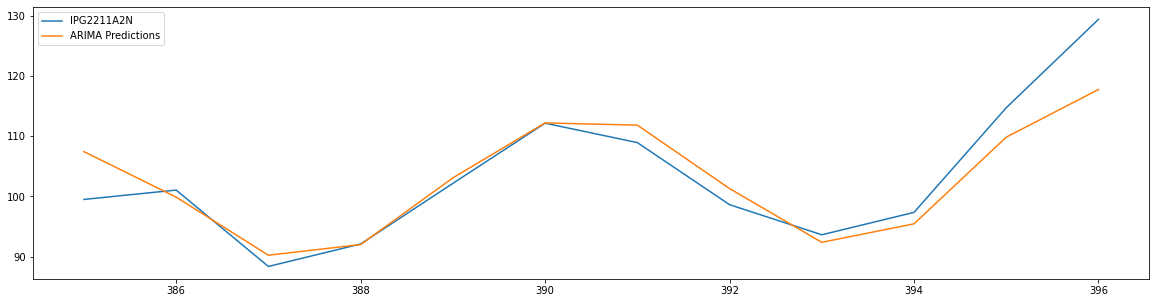

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
test_data['IPG2211A2N'].plot(figsize = (20,5), legend=True)
arima_pred.plot(legend = True);

In [ ]:
arima_rmse_error = rmse(test_data['IPG2211A2N'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['IPG2211A2N'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 20.771634485006217
RMSE Error: 4.557590864152488


## **Other method : using prophet!:)**

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [ ]:
df_prophet = df
df_prophet.columns = ['ds', 'y']

https://sigmundojr.medium.com/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7

In [ ]:
prophet = Prophet(seasonality_mode='multiplicative')
prophet.fit(df_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=6, freq='m')
forcast = prophet.predict(future)

In [ ]:
prophet_test = forcast[["ds", "yhat"]]
prophet_test = prophet_test[(402-17):(402-5)]
prophet_test

,ds,yhat
385,2017-02-01,108.771500
386,2017-03-01,102.347429
387,2017-04-01,92.310447
388,2017-05-01,92.867057
389,2017-06-01,102.257882
390,2017-07-01,110.774423
391,2017-08-01,110.642728
392,2017-09-01,100.423651
393,2017-10-01,93.042868
394,2017-11-01,96.346739


In [ ]:
prophet_test = pd.Series(prophet_test['yhat'].values, index=prophet_test['ds'])

In [ ]:
prophet_rmse_error = rmse(test_data['IPG2211A2N'], prophet_test)
prophet_mse_error = prophet_rmse_error**2
#mean_value = df['IPG2211A2N'].mean()
mean_value = df['y'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}')

MSE Error: 19.024096869012585
RMSE Error: 4.361662168143308
